# Data Description & Exploratory Data Analysis

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(utils))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages (library(infer))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

## Data Description

The [Placement Prediction Dataset](https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data) contains data which can be used to predict whether a college student gets placed or not placed in the placement process based on academic and training scores and status. The dataset contains 10000 observations and 12 variables as follows:  

**Numberical Variables:**
- `StudentID`: Unique student identifier (range 1-10000)
- `CGPA`: Cummulative grade point average achieved by each student (10-point scale)
- `Internships`: Number of internships done by each student
- `Projects`: Number of projects done by each student
- `Workshops/Certifications`: Number of online workshops and certifications each student has participated in/received
- `AptitudeTestScores`: Aptitude test scores taken to understand a student's quant and logical thinking (100-point scale)
- `SoftSkillsRating`: Soft skills rating score to evaluate a student's communication skills (5-point scale)
- `SSC_Marks`: Senior Secondary Marks (100-point scale)
- `HSC_Marks`: Higher Secondary Marks (100-point scale)

**Categorical Variables:**
- `ExtracurricularActivities`: Binary (Yes/No) indicating whether each student participates in extracurricular activities or not
- `PlacementTraining`: Binary (Yes/No) indicating whether each student participated in placement training 
- `PlacementStatus`: Binary (Placed/NotPlaced) indicating whether each student was placed or not (response variable)

### Pre-selection of variables

To start, I will drop the `StudentID` variable because it is a student identifier which tells us there is one observation per student. This will not be needed in analysis.

## Question

**The question I want to analyze is: Which input variables are significantly associated with a student's placement status?  
All variables except `StudentID` and `PlacementStatus` (response variable) will be the input variables.**

The primary focus of my question is inference because I am interested in analyzing the relationships between covariates and the response variable. 

## Exploratory Data Analysis and Visualization (no more than one plot per student)

### Load and clean data

In [2]:
# load data
url <- "https://raw.githubusercontent.com/anniew02/placement-data/main/placementdata.csv"
raw_data <- read.csv(url)
head(raw_data, 5)

# check for null values in dataset (there are none)
anyNA(raw_data)

,StudentID,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


[1] FALSE

In [3]:
# clean data
data <- raw_data %>% 
    dplyr::select(-StudentID) %>%
    mutate(across(c(PlacementStatus, ExtracurricularActivities, PlacementTraining), as.factor)) %>%
    rename("WorkshopsCertifications" = "Workshops.Certifications")
head(data, 5)

,CGPA,Internships,Projects,WorkshopsCertifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


### Data Visualizations

In [4]:
# split CGPA into quartiles
cgpa_quartiles <- data %>% 
    mutate(CGPA_quartiles = cut(CGPA,
                               breaks = quantile(CGPA, probs=c(0, 0.25, 0.50, 0.75, 1), na.rm=TRUE),
                               include.lowest=TRUE,
                               labels=c("Bottom 25%", "25-50%", "50-75%", "Top 25%")))

# cgpa_quartiles %>% count(CGPA_quartiles) #check quartile distribution
# data %>% count(Internships) #check internship distribution

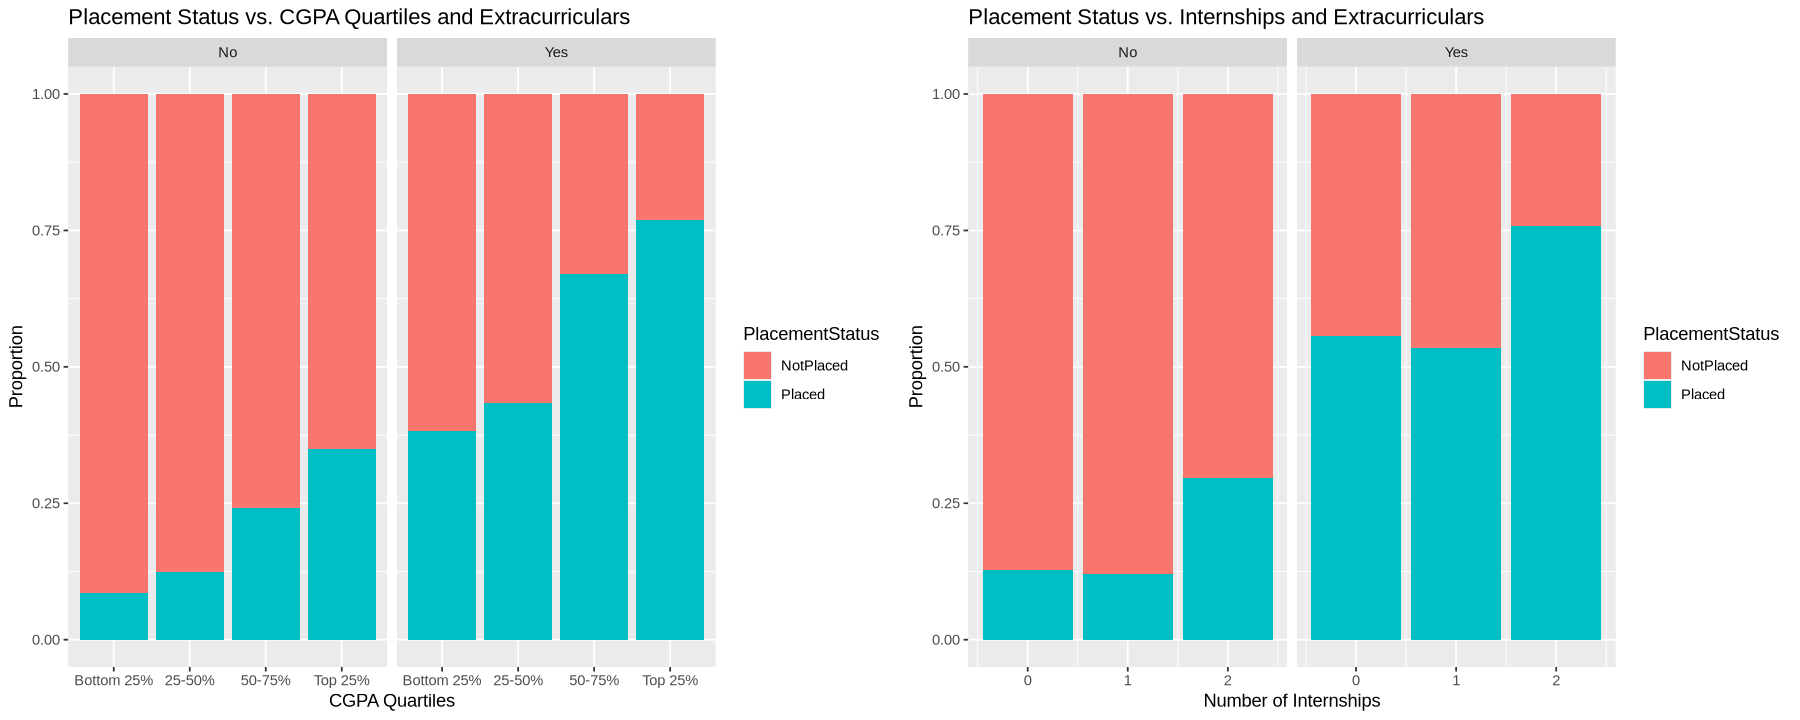

In [5]:
options(repr.plot.width = 15, repr.plot.height = 6)
p1 <- cgpa_quartiles %>% ggplot(aes(x=CGPA_quartiles, fill=PlacementStatus)) + 
        geom_bar(position="fill") +
        facet_wrap(~ExtracurricularActivities) +
        labs(title="Placement Status vs. CGPA Quartiles and Extracurriculars", 
             x="CGPA Quartiles", y="Proportion")
p2 <- data %>% ggplot(aes(x=Internships, fill=PlacementStatus)) +
        geom_bar(position="fill") +
        facet_wrap(~ExtracurricularActivities) +
        labs(title="Placement Status vs. Internships and Extracurriculars", 
             x="Number of Internships", y="Proportion")

# combined into 1 plot
plots <- plot_grid(p1, p2, ncol=2)
print(plots)

The plot to the left is a stacked bar plot that shows the proportion of students in each CGPA quartile who were placed/not placed in each extracurricular group (yes/no). It provides insights on how CGPA and extracurricular activities are associated with placement status. 

We observe that for students with no extracurricular activities, there's a greater proportion of students who were not placed in all CGPA quartiles. For students with extracurricular activities, a greater proportion of students in higher CGPA quartiles were placed and the proportions of placed and non-placed were similar for students with low-mid CGPA quartiles. **This suggests that CGPA and whether a student has extracurricular activities are associated with placement status.**

The plot on the right is a stacked bar plot that shows the proportion of students who did 0, 1, or 2 internships who were placed or not placed in each extracurricular group (yes/no). It provides insights on how the number of internships a student does and extracurricular activities are associated with placement status. 

We observe that for students with no extracurricular activities, there's a higher proportion of students who were not placed regardless of how many internships they did. For students with extracurricular activities, a higher proportion of students were placed for students, but the proportions for each number of internships are relatively similar. This suggests that the number of interships a student has done is not or weakly associated with placement status.

Some concerns so far are that the sample size of students who did 0, 1, and 2 internships is uneven which may distort the proportion of placement status.

*Note: see code comments and bolded text for changes incorporated from assignment 1 feedback.*

# Methods and Plan & Computational Code and Output

## Methods and Plan

### Binomial Logisitic Regression Model
To address my question of interest, I plan to use a binomial logisitic regression model. Binomial logistic regression models are generally used to predict the probability of a binary outcome based on one or more predictor variables which is appropriate for my question because the response variable `PlacementStatus` is binary and there are multiple predictor variables which are numerical or categorical.

### Model Assumptions
Assumptions made when using a binomial logistic regression model are that the observations are independent of each other, linearity between logit of the response and the covariates, and no multicollinearity between the covariates.

### Limitations
Some possible limitations are that if there are correlations between variables related to academic scores and variables related to experential learning, then it may be difficult to seperate the effect of either factor. 

## Computational Code and Output

In [20]:
# split the data
set.seed(875)

inference_set <- data %>%
  sample_frac(0.6, replace=FALSE) # experiment with this
selection_set <- data %>%
  setdiff(inference_set)

### Model Selection

I will improve this section in the final report, but for now I used stepwise selection in both directions to get guidance on which input variables to select in our logistic regression model. I chose to do stepwise selection in both directions because it's more robust as it adds or removes variables based on AIC.

In [21]:
full_model <- glm(formula=PlacementStatus~., data=selection_set, family=binomial)

full_model <- glm(formula=PlacementStatus~., data=selection_set, family=binomial)

In [22]:
# check for multicollinearity
vif_full <- vif(full_model)
vif_full

CGPA               Internships                  Projects 
                 1.224158                  1.134648                  1.332569 
  WorkshopsCertifications         AptitudeTestScore          SoftSkillsRating 
                 1.218580                  1.416318                  1.236120 
ExtracurricularActivities         PlacementTraining                 SSC_Marks 
                 1.293482                  1.016528                  1.319612 
                HSC_Marks 
                 1.473928

None of the VIF values are especially large which indicates there's no signs of multicollinearity in the data.

In [24]:
step_model <- stepAIC(full_model, 
                      direction="both",
                      trace=FALSE)
summary(step_model)


Call:
glm(formula = PlacementStatus ~ CGPA + Projects + AptitudeTestScore + 
    SoftSkillsRating + ExtracurricularActivities + PlacementTraining + 
    SSC_Marks + HSC_Marks, family = binomial, data = selection_set)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -18.412460   0.806716 -22.824  < 2e-16 ***
CGPA                           0.425080   0.077742   5.468 4.56e-08 ***
Projects                       0.308611   0.058711   5.256 1.47e-07 ***
AptitudeTestScore              0.067823   0.007442   9.113  < 2e-16 ***
SoftSkillsRating               0.768679   0.132884   5.785 7.27e-09 ***
ExtracurricularActivitiesYes   0.665144   0.106291   6.258 3.91e-10 ***
PlacementTrainingYes           1.003863   0.112101   8.955  < 2e-16 ***
SSC_Marks                      0.027837   0.005009   5.557 2.74e-08 ***
HSC_Marks                      0.027876   0.006026   4.626 3.73e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

The stepwise selection process removed `Internships` and `WorkshopsCertifications` from the full model which suggests that they're not as useful for making an inference on a student's placement status.

In [26]:
vif <- vif(step_model)
vif

CGPA                  Projects         AptitudeTestScore 
                 1.200056                  1.322038                  1.394001 
         SoftSkillsRating ExtracurricularActivities         PlacementTraining 
                 1.226001                  1.278693                  1.015466 
                SSC_Marks                 HSC_Marks 
                 1.309600                  1.441456

I checked for multicollinearity again after model selection and there still doesn't seem to be any signs of multicollinearity because none of the VIF values are especially large. This shows the multicollinearity assumption isn't violated.

### Method Implementation

In [28]:
logr_model <- glm(formula = PlacementStatus~.-Internships-WorkshopsCertifications,
             data=inference_set, 
             family=binomial)

tidy(logr_model, exponentiate=TRUE, conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.110246e-08,0.661716614,-27.679672,1.226765e-168,2.996147e-09,4.011299e-08
CGPA,1.478084e+00,0.065081273,6.003981,1.925376e-09,1.301331e+00,1.679612e+00
Projects,1.278682e+00,0.048144407,5.106093,3.288876e-07,1.163337e+00,1.405023e+00
AptitudeTestScore,1.077144e+00,0.005960149,12.468264,1.112225e-35,1.064678e+00,1.089851e+00
SoftSkillsRating,1.890438e+00,0.108508143,5.868761,4.390633e-09,1.528788e+00,2.339444e+00
ExtracurricularActivitiesYes,2.320165e+00,0.086164860,9.767766,1.548284e-22,1.959943e+00,2.747687e+00
PlacementTrainingYes,2.334072e+00,0.092645803,9.148976,5.747582e-20,1.948299e+00,2.801746e+00
SSC_Marks,1.031321e+00,0.004047564,7.619496,2.546680e-14,1.023173e+00,1.039540e+00
HSC_Marks,1.031450e+00,0.004856714,6.375824,1.819820e-10,1.021673e+00,1.041314e+00


### Results

After fitting the selected variables to a logistic regression model, it's observed that `CGPA`, `Projects`, `AptitudeTestScore`, `SoftSkillsRating`, `ExtracurricularActivitiesYes`, `PlacementTrainingYes`, `SSC_Marks`, and `HSC_Marks` are significantly associated with a student's placement status at 5% significance level because all these variables were selected in our stewpise model and their p-values are less than 0.05. 

In my exploratory analysis, I focused on the associations between a student's CGPA, extracurricular activities, and internships with their placement status and my analysis here agrees with my preliminary observations that there's evidence that CGPA and extracurricular activities are associated but not enough evidence for internships. The model indicates that a 1-point increase in a student's CGPA is associated with an increase the odds of being placed by a factor of 1.50 (50%) while holding all variables constant and students who participate in extracurricular activities are associated with increased odds of being placed by a factor of 2.16 (116%) compared to students without extracurricular activities while holding all other variables constant. It's unexpected that there was insufficient evidence of internships being associated with placement status because in real-life applications, I would expect work experience to be valuable when being placed. This could be due to underlying data limitations or the variation being explained by other variables.